In [116]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numbers

In [132]:
class MyLinearRegression():
	def __init__(self, thetas, alpha=0.001, max_iter=10000):
		if  not isinstance(thetas, np.ndarray) or not isinstance(alpha, float) or not isinstance(max_iter, int):
			print("Error Init 1")
			return
		elif thetas.size <= 0 or alpha <= 0 or max_iter <= 0:
			print("Error Init 2")
			return
		elif thetas.ndim != 2 or thetas.shape[1] != 1:
			print("Error Init 3")
			return
		self.thetas = thetas
		self.alpha = alpha
		self.max_iter = max_iter
	
	def zscore(self, x):
		if not isinstance(x, np.ndarray):
			return
		elif x.size <= 0 or x.ndim != 2:
			return
		return (x - x.mean()) / x.std()

	def minmax(self, x, x_min=None, x_max=None):
		if not isinstance(x, np.ndarray):
			return
		elif x.size <= 0 or x.ndim != 2:
			return
		if x_min is None or x_max is None:
			x_min = x.min(axis=0)
			x_max = x.max(axis=0)	

		return (x - x_min) / (x_max - x_min), x_min, x_max

	def predict_(self, x):
		if not isinstance(x, np.ndarray) or not isinstance(self.thetas, np.ndarray):
			return
		elif x.size <= 0 or self.thetas.size <= 0:
			return
		elif x.ndim != 2 or self.thetas.ndim != 2:
			return

		m, n = x.shape

		X_Prime = np.hstack((np.ones((m, 1)), x))

		if self.thetas.shape != (n + 1, 1):
			return

		return X_Prime @ self.thetas
	
	def mse_(self, y, y_hat):
		if not isinstance(y, np.ndarray) or not isinstance(y_hat, np.ndarray):
			return
		if y.size <= 0 or y_hat.size <= 0:
			return
		if y.ndim != 2 or y_hat.ndim != 2 or y.ndim != y_hat.ndim:
			return
		m = y.shape[0]

		error = y_hat - y

		return (1 / m) * (error.T @ error)

	def mae_(self, y, y_hat):
		if y.size <= 0 or y_hat.size <= 0:
			return
		if y.ndim != 2 or y_hat.ndim != 2 or y.ndim != y_hat.ndim:
			return
		m = y.shape[0]

		return (1 / m) * np.sum(np.abs(y_hat - y))
		
	def rmse_(self, y, y_hat):
		if y.size <= 0 or y_hat.size <= 0:
			return
		if y.ndim != 2 or y_hat.ndim != 2 or y.ndim != y_hat.ndim:
			return
		return np.sqrt(self.mse_(y, y_hat))

	def fit_(self, x, y):
		if not isinstance(x, np.ndarray) or not isinstance(y, np.ndarray) or not isinstance(self.thetas, np.ndarray):
			print("Error: Fit 1")
			return
		elif x.size <= 0 or y.size <= 0 or self.thetas.size <= 0:
			print("Error: Fit 2")
			return
		elif x.ndim != 2 or y.ndim != 2 or self.thetas.ndim != 2:
			print("Error: Fit 3")
			return
		m, n = x.shape
		if y.shape != (m, 1) or self.thetas.shape != (n + 1, 1):
			print("Error: Fit 4")
			return

		self.thetas = self.thetas.astype(np.float64)
		
		for _ in range(self.max_iter):
			y_hat = self.predict_(x)

			error = y_hat - y

			X_Prime = np.hstack((np.ones((m, 1)), x))

			gradient = (1 / m) * (X_Prime.T @ error)

			self.thetas -= self.alpha * gradient


In [118]:
def add_polynomial_features(x, power):
	if not isinstance(x, np.ndarray) or not isinstance(power, int):
		return
	if x.size <= 0 or x.ndim != 2:
		return

	X_Pow = x.copy()

	for i in range(power):
		if (i > 0):
			X_Pow = np.hstack((X_Pow, pow(x, i + 1)))
	
	return X_Pow

In [119]:
def data_spliter(x, y, proportion):
	if not isinstance(x, np.ndarray) or not isinstance(y, np.ndarray) or not isinstance(proportion, float):
		return
	if x.size <= 0 or y.size <= 0 or proportion <= 0.0 or proportion >= 1.0:
		return
	if x.ndim != 2 or y.ndim != 2:
		return
	if x.shape[0] != y.shape[0] or y.shape[1] != 1:
		return
	
	rng = np.random.default_rng(42)
	indices = np.arange(x.shape[0])
	rng.shuffle(indices)
	X_shuffled = x[indices]
	Y_shuffled = y[indices]

	trainingSet = int(x.shape[0] * proportion)

	X_trainset = X_shuffled[:trainingSet]
	Y_trainset = Y_shuffled[:trainingSet]
	X_testing = X_shuffled[trainingSet:]
	Y_testing = Y_shuffled[trainingSet:]

	#print(repr((X_trainset, X_testing, Y_trainset, Y_testing)))

	return (X_trainset, X_testing, Y_trainset, Y_testing)

(4900, 3)
(4900, 1)


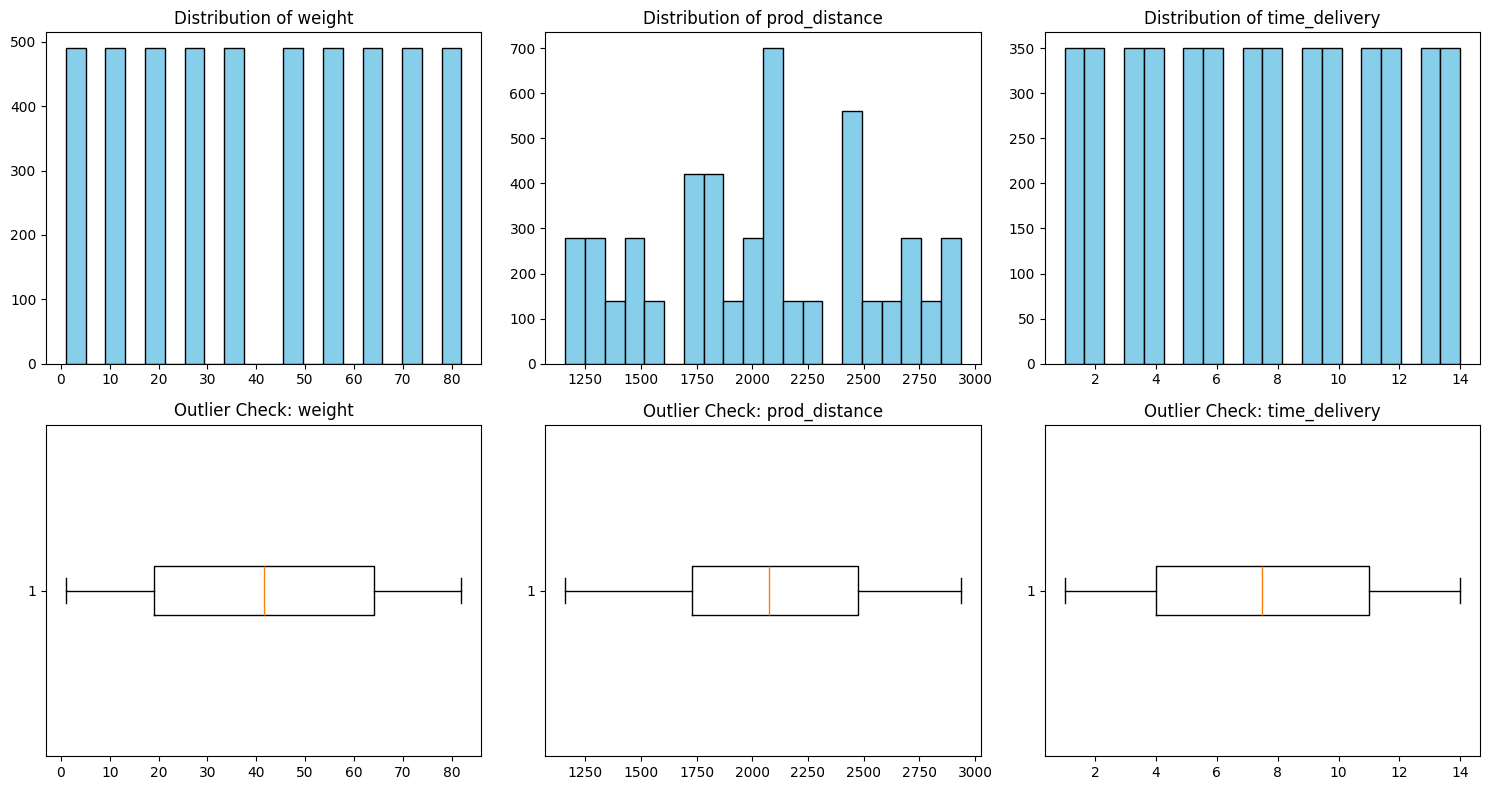

In [120]:
#Extracting Dataset into numpy array and splitting them between X and Y
dataset = np.array(pd.read_csv("space_avocado.csv"))

X = dataset[:, 1:-1:]
Y = dataset[:, -1].reshape(-1, 1)
print(X.shape)
print(Y.shape)

#Analyzing Dataset Distribution to pick the right normalization algorithm
features = ['weight', 'prod_distance', 'time_delivery']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for i, col in enumerate(features):
    # Histogram - Checking for shape/distribution
    axes[0, i].hist(X[:, i], bins=20, color='skyblue', edgecolor='black')
    axes[0, i].set_title(f'Distribution of {col}')
    
    # Boxplot - Checking for OUTLIERS
    axes[1, i].boxplot(X[:, i], vert=False)
    axes[1, i].set_title(f'Outlier Check: {col}')

plt.tight_layout()
plt.show()
#No apparent Outlier => we will use Minmax normalization algorithm

In [134]:

#Split Dataset into training (80%) and testing set (20%)
X_train, X_test, Y_train, Y_test = data_spliter(X, Y, 0.8)
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

#Create a template model to use normalization method
model = MyLinearRegression(np.ones(2).reshape(-1, 1))

#Create 4 polynomial training/testing set from degree 1 to 4
X_train_poly_1, x_min_1, x_max_1 = model.minmax(X_train.copy())
X_train_poly_2, x_min_2, x_max_2 = model.minmax(add_polynomial_features(X_train, 2))
X_train_poly_3, x_min_3, x_max_3 = model.minmax(add_polynomial_features(X_train, 3))
X_train_poly_4, x_min_4, x_max_4 = model.minmax(add_polynomial_features(X_train, 4))
print(X_train_poly_4.shape)

X_test_poly_1, _, _ = model.minmax(X_test.copy(), x_min_1, x_max_1)
X_test_poly_2, _, _ = model.minmax(add_polynomial_features(X_test, 2), x_min_2, x_max_2)
X_test_poly_3, _, _ = model.minmax(add_polynomial_features(X_test, 3), x_min_3, x_max_3)
X_test_poly_4, _, _ = model.minmax(add_polynomial_features(X_test, 4), x_min_4, x_max_4)
print(X_test_poly_4.shape)

(3920, 3) (980, 3)
(3920, 1) (980, 1)
(3920, 12)
(980, 12)


[[-0.007101  ]
 [ 0.00417244]
 [ 0.01043438]
 [-0.01885956]]
[  64. 1346.    2.]
[0.77777778 0.10422535 0.07692308]


In [150]:
""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""				TRAINING MODEL 1					"""
""""""""""""""""""""""""""""""""""""""""""""""""""""""""

#Create Random Thetas (Normal distribution, mean of 0, standard deviation of 0.01)
thetas_1 = np.random.normal(0, 0.01, size=X_train_poly_1.shape[1] + 1).reshape(-1, 1)
print(thetas_1)
print(X_test[0])
print(X_test_poly_1[0])

#Train Model 1 (Using Training set)
pm_1 = MyLinearRegression(thetas_1, 0.1, max_iter=100000)
pm_1.fit_(X_train_poly_1, Y_train)

[[ 0.01494752]
 [ 0.00620407]
 [-0.00128095]
 [-0.00158534]]
[  64. 1346.    2.]
[0.77777778 0.10422535 0.07692308]


KeyboardInterrupt: 

31237.777000


' Y_Hat_1 = pm_1.predict_(X_test_poly_1)\nloss_test_1 = pm_1.rmse_(Y_test, Y_Hat_1)\nprint(f"{loss_test_1.item():f}") '

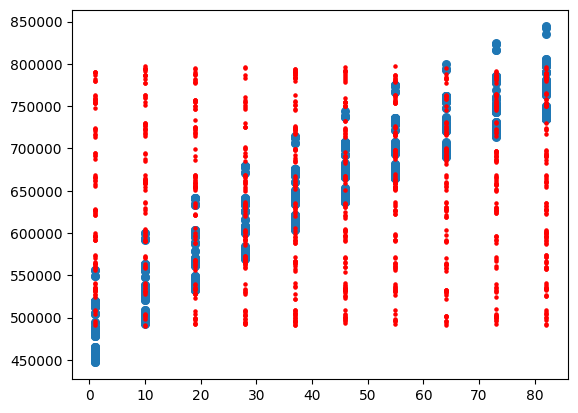

In [149]:

""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""			LOSS AND VISUALIATION MODEL 1			"""
""""""""""""""""""""""""""""""""""""""""""""""""""""""""

#Calculate Loss Model 1 Using Training Set
Y_Hat_1 = pm_1.predict_(X_train_poly_1)
loss_train_1 = pm_1.rmse_(Y_train, Y_Hat_1)
print(f"{loss_train_1.item():f}")

sorted_indices = np.argsort(X_test[:, 0]) # Sort by the first feature (Weight)
X_sorted = X_test[sorted_indices]
Y_hat_sorted = Y_Hat_1[sorted_indices]

plt.scatter(X_test[:, 0], Y_test, label="Actual", s=30)
plt.scatter(X_sorted[:, 0], Y_hat_sorted, color="red", label="Polynomial Fit", s=5)
plt.plot()

#Visualize Results of Model 1 Training Set (Weight)
""" x_min_train_weight = X_train.min(axis=0)
x_max_train_wieght = X_train.max(axis=0)
X_test_continue = np.linspace(x_min_train, x_max_train, 200).reshape(-1, 1) """



#Calculate Loss Model 1 Using Testing Set
""" Y_Hat_1 = pm_1.predict_(X_test_poly_1)
loss_test_1 = pm_1.rmse_(Y_test, Y_Hat_1)
print(f"{loss_test_1.item():f}") """



